In [13]:
!pip install langgraph langchain python-dotenv langchain-anthropic pandas pyarrow pydantic -q -U
!apt-get install -qq graphviz libgraphviz-dev # Install system library quietly
!pip install -q pygraphviz # Install Python wrapper quietly

In [1]:
# -*- coding: utf-8 -*-
"""
01_llm_verification_reflection_agent.ipynb

Alternative solution using a LangGraph Reflection Agent pattern
for the Grainger LLM Verification task, using separate Generator and Critic models.
"""

'\n01_llm_verification_reflection_agent.ipynb\n\nAlternative solution using a LangGraph Reflection Agent pattern\nfor the Grainger LLM Verification task, using separate Generator and Critic models.\n'

In [2]:
# --- Environment Setup ---
import os
import pandas as pd
import time
import numpy as np # Import numpy for NA checks if needed
from dotenv import load_dotenv
import json
import warnings
from typing import TypedDict, List, Optional, Annotated, Dict, Any
from IPython.display import Image, display
import logging

# LangChain & LangGraph imports
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field # Using v1 for broader compatibility
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages

# --- Load Environment Variables ---
## --- Load Environment Variables using Colab Secrets ---
try:
    from google.colab import userdata
    ANTHROPIC_API_KEY = userdata.get('ANTHROPIC_API_KEY')
    if not ANTHROPIC_API_KEY:
        raise ValueError("ANTHROPIC_API_KEY not found in Colab Secrets. Please add it.")
    else:
        print("ANTHROPIC_API_KEY loaded successfully from Colab Secrets.")
    # No need to set os.environ explicitly if passing the key directly to the client later
except ImportError:
    print("Could not import google.colab.userdata. Are you running in Colab?")
    # Fallback or error handling if not in Colab
    raise EnvironmentError("Not running in Colab and Colab Secrets unavailable.")

# --- Configuration ---
# LLM Initialization
GENERATOR_MODEL_NAME = "claude-3-5-sonnet-20241022" #
CRITIC_MODEL_NAME = "claude-3-7-sonnet-latest"

try:
    # Pass the key explicitly for clarity and robustness
    generator_llm = ChatAnthropic(
        model=GENERATOR_MODEL_NAME,
        temperature=0.1,
        anthropic_api_key=ANTHROPIC_API_KEY # Pass the loaded key
    )
    print(f"Generator LLM initialized: {GENERATOR_MODEL_NAME}")

    critic_llm = ChatAnthropic(
        model=CRITIC_MODEL_NAME,
        temperature=0.0,
        anthropic_api_key=ANTHROPIC_API_KEY # Pass the loaded key
    )
    print(f"Critic LLM initialized: {CRITIC_MODEL_NAME}")

except Exception as e:
    print(f"Error initializing Anthropic models: {e}")
    raise

# .configuration: Data Path, MAX_ITERATIONS, Output file
PROCESSED_DATA_PATH = '/content/drive/MyDrive/Colab_Data/Grainger_LLM_Exercise/filtered_data_with_context_2025-04-22.parquet'
MAX_ITERATIONS = 3
REFLECTION_RESULTS_CSV = "results/grainger_llm_reflection_results_multi_model_04_23.csv"
os.makedirs("results", exist_ok=True)

print("Setup Complete.")

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


ANTHROPIC_API_KEY loaded successfully from Colab Secrets.
Generator LLM initialized: claude-3-5-sonnet-20241022
Critic LLM initialized: claude-3-7-sonnet-latest
Setup Complete.


In [3]:
# --- Mount Google Drive ---
from google.colab import drive
try:
    # Add force_remount=True
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    raise SystemExit("Google Drive mount failed. Cannot proceed.")

# Optional: Verify the file exists after mounting
import os
# Use the same PROCESSED_DATA_PATH variable
if os.path.exists(PROCESSED_DATA_PATH):
    print(f"Verified: File exists at {PROCESSED_DATA_PATH}")
else:
    print(f"WARNING: File NOT found at {PROCESSED_DATA_PATH} after mounting.")
    print("Please double-check the path and filename in your Google Drive.")
    # List contents of the expected directory to help debug
    expected_dir = os.path.dirname(PROCESSED_DATA_PATH)
    if os.path.exists(expected_dir):
         print(f"Contents of {expected_dir}:")
         try:
             print(os.listdir(expected_dir))
         except Exception as list_e:
             print(f"Could not list directory contents: {list_e}")
    else:
         print(f"Directory {expected_dir} does not exist.")

Mounted at /content/drive
Google Drive mounted successfully.
Verified: File exists at /content/drive/MyDrive/Colab_Data/Grainger_LLM_Exercise/filtered_data_with_context_2025-04-22.parquet


In [5]:
# --- Load Preprocessed Data from end to end worfklow notebook  step 6.6---
try:
    # Ensure the path is correct for your environment (Colab Drive vs local)
    df_input = pd.read_parquet(PROCESSED_DATA_PATH)
    print(f"Loaded data from {PROCESSED_DATA_PATH}. Shape: {df_input.shape}")
    # Ensure required columns are present
    required_cols = ['query_id', 'product_id', 'query', 'llm_product_context']
    if not all(col in df_input.columns for col in required_cols):
        missing = [col for col in required_cols if col not in df_input.columns]
        raise ValueError(f"Missing required columns in input data: {missing}")
    if df_input.empty:
         raise ValueError("Input DataFrame is empty.")
except FileNotFoundError:
    print(f"ERROR: Processed data file not found at {PROCESSED_DATA_PATH}")
    print("Please ensure the file exists or run the data preparation steps first.")
    # Handle error appropriately, e.g., raise SystemExit or run data prep
    raise
except Exception as e:
    print(f"ERROR loading data: {e}")
    raise



# --- Pydantic Model for Structured Output ---
class VerificationResult(BaseModel):
    """Structured output for the verification task."""
    is_exact_match: bool = Field(description="True if the product is an exact match based on the rules, False otherwise.")
    reasoning: str = Field(description="Concise explanation citing the specific rule and evidence (contradiction or confirmation/missing info). Max 1-2 sentences.")
    reformulated_query: Optional[str] = Field(description="If is_exact_match is False, the corrected query. Must be null if is_exact_match is True.")

# --- Prompts ---
VERIFIER_PROMPT_TEMPLATE = ChatPromptTemplate.from_messages([
    ("system", """You are an extremely precise AI Data Quality Analyst. Your task is to verify if the Product Information makes the product an "Exact" match for the Search Query based *only* on the provided text and strict rules.

**Definition of Exact Match ('E'):**
The Product is relevant for the Query AND satisfies ALL specifications mentioned in the Query.

**Crucial Rules:**
1.  **Contradiction Rule:** If Product Info EXPLICITLY CONTRADICTS a Query specification (e.g., query "100 pack", product "50 count"; query "without shams", product "includes shams"), it's NOT Exact. Mark `is_exact_match: false`.
2.  **Missing Information Rule:** If Product Info DOES NOT MENTION a query spec (e.g., query "gyroscopic", feature not mentioned), assume it MIGHT satisfy it. DO NOT mark as non-Exact based *only* on missing info. It remains an Exact candidate (`is_exact_match: true` unless Rule 1 applies).
3.  **Extra Information Rule:** Extra product details NOT in the query are acceptable if Rule 1 isn't violated.

**Input:**
Search Query: "{query}"
Product Information:
--- START ---
{product_context}
--- END ---

**Output:**
Respond ONLY with a valid JSON object adhering to the VerificationResult schema. Provide clear reasoning based *directly* on the rules and text. If false, formulate a concise, accurate query based on the product details provided. If true, reformulated_query MUST be null."""),
    ("human", "Analyze the provided query and product information according to the rules and provide your assessment in the required JSON format.")
])

REFLECTOR_PROMPT_TEMPLATE = ChatPromptTemplate.from_messages([
    ("system", """You are a meticulous Quality Assurance expert evaluating an AI's verification judgment. Your goal is to ensure the AI strictly followed the rules and produced a correct, well-reasoned assessment.

**Evaluation Context:**
Original Search Query: "{query}"
Product Information:
--- START ---
{product_context}
--- END ---

AI Verifier's Assessment (JSON):
```json
{assessment_json}

Your Task:
Critically evaluate the AI Verifier's Assessment based only on the provided Query, Product Information, and these Crucial Rules:
Contradiction Rule: Was any EXPLICIT CONTRADICTION between Query and Product Info correctly identified (leading to is_exact_match: false)? Or was a contradiction missed?
Missing Information Rule: Was the rule applied correctly? Did the AI correctly determine is_exact_match: true when information was merely missing (and no contradiction existed)? Or did it incorrectly flag missing info as a reason for is_exact_match: false?
Reasoning Quality: Is the reasoning accurate, concise, and directly supported by the text and rules? Does it clearly state the basis (contradiction found, or spec met/missing)?
Reformulation Quality: If is_exact_match: false, is the reformulated_query accurate based on the product info, relevant to the original query's intent, and concise? Is it correctly null if is_exact_match: true?
JSON Validity: Is the assessment a valid JSON matching the required schema? (Assume basic validity if parsed).

Output:
If the AI's Assessment is PERFECT and strictly adheres to all rules: Respond ONLY with the word ACCEPT.
If there are ANY flaws (rule misapplication, poor reasoning, incorrect reformulation, wrong null handling): Provide a concise, actionable critique (1-3 sentences) explaining EXACTLY what needs to be fixed. Focus on the most critical error if multiple exist. Do NOT provide the corrected JSON yourself."""),
("human", "Evaluate the AI Verifier's Assessment based on the rules and context. Provide your critique or 'ACCEPT'.")
])


REVISER_PROMPT_TEMPLATE = ChatPromptTemplate.from_messages([
("system", """You are an AI Data Quality Analyst revising your previous assessment based on critique.

Original Task & Rules (Reminder):
Verify if the Product Information makes the product an "Exact" match for the Search Query based on the rules below. Output valid JSON.
Definition Exact ('E'): Relevant AND satisfies ALL query specs.
Rule 1 (Contradiction): Explicit contradiction -> is_exact_match: false.
Rule 2 (Missing Info): Spec not mentioned -> Assume OK (is_exact_match: true unless Rule 1 applies).
Rule 3 (Extra Info): Extra product details OK if no contradiction.
Context:
Search Query: "{query}"
Product Information:
--- START ---
{product_context}
--- END ---
Your Previous Assessment (JSON):
{previous_assessment_json}

Critique Received:
"{critique}"

Your Task:
Carefully consider the Critique. Re-evaluate the Query and Product Information based only on the original Rules and the specific points raised in the Critique.
Generate a revised, valid JSON object adhering to the VerificationResult schema, addressing the critique accurately. Ensure reformulated_query is null if is_exact_match is true."""),
("human", "Revise your assessment based on the critique and rules. Provide the updated JSON output.")
])


Loaded data from /content/drive/MyDrive/Colab_Data/Grainger_LLM_Exercise/filtered_data_with_context_2025-04-22.parquet. Shape: (24, 15)


Core Components Defined (Pydantic Model, Prompts, Structured LLM binding).
LangGraph Application Compiled.

Attempting to visualize the graph...
Displaying Mermaid PNG:


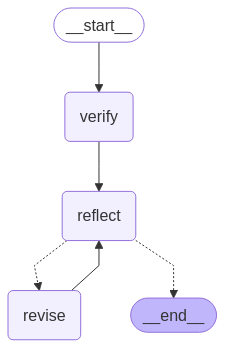

In [6]:
# --- Bind the GENERATOR LLM for structured output ---
# Ensure generator_llm is defined from the setup block
structured_llm_generator = generator_llm.with_structured_output(VerificationResult)

print("Core Components Defined (Pydantic Model, Prompts, Structured LLM binding).")


# --- LangGraph State Definition ---
# The state defines the data that flows through the graph.
# Each node updates parts of this state.
class VerificationState(TypedDict):
    query: str                      # Input: The user's search query
    product_context: str            # Input: The aggregated product information
    assessment: Optional[VerificationResult] # Output of verify/revise: The current JSON assessment
    critique: Optional[str]         # Output of reflect: The critique text or "ACCEPT"
    revision_number: int            # Internal counter for reflection cycles
    error: Optional[str]            # Captures errors from nodes


# --- Graph Node Definitions ---
# Nodes are functions that perform actions and update the state.

def initial_verify(state: VerificationState) -> Dict[str, Any]:
    """
    Node: Performs the first verification attempt.
    Input: query, product_context
    Output: assessment, error, revision_number (incremented)
    LLM Used: Generator (structured output)
    """
    print(f"--- Iteration {state['revision_number']}: Initial Verification (using {GENERATOR_MODEL_NAME}) ---")
    query = state['query']
    product_context = state['product_context']
    error = None
    assessment = None
    try:
        prompt = VERIFIER_PROMPT_TEMPLATE.format(query=query, product_context=product_context)
        assessment = structured_llm_generator.invoke(prompt) # Call LLM for structured JSON
        print(f"Initial Assessment: {assessment.json(indent=2)}")
    except Exception as e:
        print(f"ERROR in initial_verify: {e}")
        error = f"Failed during initial verification: {e}"
    # Increment revision number for the next potential cycle
    return {"assessment": assessment, "error": error, "revision_number": state.get("revision_number", 0) + 1}

def reflect(state: VerificationState) -> Dict[str, Any]:
    """
    Node: Critiques the current assessment.
    Input: query, product_context, assessment, error (from previous step)
    Output: critique, error
    LLM Used: Critic
    """
    current_revision = state.get("revision_number", 1) # Revision number *after* verify/revise
    print(f"--- Iteration {current_revision - 1}: Reflection (using {CRITIC_MODEL_NAME}) ---")
    if state.get("error"): # If verify/revise failed, skip reflection
        print("Skipping reflection due to previous error.")
        return {"critique": "Previous step failed", "error": state.get("error")}

    query = state['query']
    product_context = state['product_context']
    assessment = state['assessment']
    critique = None
    error = None

    if not assessment: # Should not happen if verify worked, but check defensively
        error = "Cannot reflect: No assessment provided from previous step."
        print(error)
        return {"critique": None, "error": error}

    try:
        assessment_json_str = assessment.json()
        prompt = REFLECTOR_PROMPT_TEMPLATE.format(
            query=query,
            product_context=product_context,
            assessment_json=assessment_json_str
        )
        response = critic_llm.invoke(prompt) # Use the critic LLM
        critique = response.content.strip()
        print(f"Reflection Critique: {critique}")
    except Exception as e:
        print(f"ERROR in reflect: {e}")
        error = f"Failed during reflection: {e}"

    # Standardize the acceptance signal
    if critique and critique.upper() == "ACCEPT":
        critique = "ACCEPT"

    # Return the critique; revision number doesn't change in this step's output
    return {"critique": critique, "error": error}


def revise(state: VerificationState) -> Dict[str, Any]:
    """
    Node: Revises the assessment based on the critique.
    Input: query, product_context, assessment, critique, revision_number, error
    Output: assessment (updated), error, revision_number (incremented)
    LLM Used: Generator (structured output)
    """
    current_revision = state.get("revision_number", 1) # Revision number *before* this revision
    print(f"--- Iteration {current_revision - 1}: Revision (using {GENERATOR_MODEL_NAME}) ---")
    if state.get("error"): # If reflection failed, skip revision
        print("Skipping revision due to previous error.")
        # Pass along previous state's assessment and error
        return {"assessment": state.get("assessment"), "error": state.get("error"), "revision_number": current_revision}

    query = state['query']
    product_context = state['product_context']
    previous_assessment = state['assessment']
    critique = state['critique']
    revised_assessment = None
    error = None

    # This node should only run if critique is NOT "ACCEPT"
    if not previous_assessment or not critique or critique == "ACCEPT":
        error = "Revise node called inappropriately (no assessment/critique or critique was ACCEPT)."
        print(f"WARNING: {error}")
        # Return previous state without incrementing revision number if called incorrectly
        return {"assessment": previous_assessment, "error": error, "revision_number": current_revision}

    try:
        previous_assessment_json_str = previous_assessment.json()
        prompt = REVISER_PROMPT_TEMPLATE.format(
            query=query,
            product_context=product_context,
            previous_assessment_json=previous_assessment_json_str,
            critique=critique
        )
        revised_assessment = structured_llm_generator.invoke(prompt) # Use generator for structured output
        print(f"Revised Assessment: {revised_assessment.json(indent=2)}")
    except Exception as e:
        print(f"ERROR in revise: {e}")
        error = f"Failed during revision: {e}"
        # Keep the previous assessment if revision fails to avoid losing progress
        revised_assessment = previous_assessment

    # Return the revised assessment and increment revision number for the next cycle
    return {"assessment": revised_assessment, "error": error, "revision_number": current_revision + 1}


# --- Conditional Edge Logic ---
# This function directs the flow of the graph after the 'reflect' node runs.
def decide_to_finish(state: VerificationState) -> str:
    """
    Determines the next step after reflection: revise or end the process.
    Input: The current state after the 'reflect' node.
    Output: A string representing the next node ('revise') or the end state (END).
    """
    error = state.get("error")
    critique = state.get("critique")
    # revision_number reflects the *upcoming* cycle attempt number (e.g., 1 after initial verify)
    revision_number = state.get("revision_number", 0)

    print(f"Decision Check: Error='{error}', Critique='{critique}', Revision Cycle Attempt='{revision_number}'")

    # Prioritize ending on critical errors from verify or reflect
    is_critical_error = error and "Revise node called inappropriately" not in error

    if is_critical_error:
        print(f"Deciding to finish due to critical error: {error}")
        return END # Stop the graph execution for this item
    elif critique == "ACCEPT":
        print("Deciding to finish: Reflection accepted.")
        return END # Stop the graph, the assessment is good
    elif revision_number > MAX_ITERATIONS: # Have we exceeded the allowed cycles?
        print(f"Deciding to finish: Max iterations ({MAX_ITERATIONS}) reached.")
        return END # Stop the graph due to hitting the limit
    else:
        # If no error, not accepted, and within iteration limit, proceed to revise
        print("Deciding to revise.")
        return "revise" # Route to the 'revise' node

# --- Build the Graph ---
# We are building the reflection logic manually using LangGraph's core components.
# We are *not* using the separate `langgraph-reflection` helper library here.
# This gives us more control over the specific flow and state management.

workflow = StateGraph(VerificationState)

# Add the defined functions as nodes in the graph
workflow.add_node("verify", initial_verify)
workflow.add_node("reflect", reflect)
workflow.add_node("revise", revise)

# Define the starting point of the graph
workflow.set_entry_point("verify")

# Define the connections (edges) between nodes
workflow.add_edge("verify", "reflect") # Always go from initial verification to reflection

# Add conditional logic after the 'reflect' node
workflow.add_conditional_edges(
    "reflect",          # The source node
    decide_to_finish,   # The function that decides the next step
    {
        "revise": "revise", # If decide_to_finish returns "revise", go to the 'revise' node
        END: END            # If decide_to_finish returns END, terminate the graph for this run
    }
)

# Define the loop: after revising, go back to reflect on the revision
workflow.add_edge("revise", "reflect")

# Compile the graph into a runnable application object
app = workflow.compile()
print("LangGraph Application Compiled.")

# --- Visualize the graph ---
print("\nAttempting to visualize the graph...")
try:
    img_data = app.get_graph().draw_mermaid_png() # Generate the graph image
    if img_data:
        print("Displaying Mermaid PNG:")
        display(Image(img_data)) # Display in the notebook
    else:
        # Fallback if PNG generation fails but no error is raised
        print("draw_mermaid_png() did not return image data. Graphviz might have issues.")
        print("Attempting fallback with draw_ascii()...")
        try:
            ascii_graph = app.get_graph().draw_ascii()
            print("\nASCII Representation of the Graph:")
            print(ascii_graph)
        except Exception as ascii_e:
            print(f"Could not draw ASCII graph either: {ascii_e}")

except ImportError as e:
    # Catch if pygraphviz is missing
    print(f"ImportError: {e}. Visualization requires pygraphviz and graphviz system library.")
    print("Install with: !apt-get install -qq graphviz libgraphviz-dev && pip install -q pygraphviz")
except Exception as e:
    # Catch other errors during visualization
    print(f"Could not draw graph: {e}")
    print("Attempting fallback with draw_ascii()...")
    try:
        ascii_graph = app.get_graph().draw_ascii()
        print("\nASCII Representation of the Graph:")
        print(ascii_graph)
    except Exception as ascii_e:
        print(f"Could not draw ASCII graph either: {ascii_e}")

In [7]:
# --- Run the Workflow for Each Row ---
results_list = []
from tqdm.auto import tqdm
import time
import numpy as np # Import numpy for NA checks if needed
import pandas as pd # Ensure pandas is imported if running this cell separately

print(f"\nStarting Reflection Agent Workflow for {len(df_input)} items...")

start_overall_time = time.time()

# Iterate through each row of the prepared DataFrame
for index, row in tqdm(df_input.iterrows(), total=len(df_input), desc="Processing Items"):
    query_id = row['query_id']
    product_id = row['product_id']
    query = row['query']
    # Handle potential missing context robustly
    context = row.get('llm_product_context', "Product information missing.")
    if pd.isna(context) or not context:
         context = "Product information missing."

    print(f"\n===== Processing Item {index+1}/{len(df_input)} (PID: {product_id}) =====")
    # Define the initial state for this item's graph run
    initial_state = VerificationState(
        query=query,
        product_context=context,
        assessment=None,
        critique=None,
        revision_number=0, # Start revision count at 0 (will become 1 after initial_verify)
        error=None,
    )

    final_state = None
    # Initialize a dictionary to store the results for this specific item
    item_result = {
        'query_id': query_id,
        'product_id': product_id,
        'accurate_label': None, # Default to None (will be updated based on final assessment)
        'reformulated_query': None, # Default to None
        'final_reasoning': "Workflow did not produce a final assessment.", # Default message
        'iterations': 0, # Number of revision cycles (0 means only initial verify + reflect)
        'final_outcome': "Unknown" # Tracks how the graph ended (Accepted, Error, Max Iterations)
    }

    try:
        # Execute the compiled LangGraph application for this item's initial state
        # The recursion_limit prevents infinite loops if something goes wrong
        final_state = app.invoke(initial_state, {"recursion_limit": MAX_ITERATIONS * 2 + 5})

        # Process the final state returned by the graph after it reaches END
        if final_state:
            # Calculate the number of revision cycles completed
            # revision_number in the final state is the number of the *next* cycle attempt
            item_result['iterations'] = final_state.get('revision_number', 1) - 1 # Iteration 0 is initial verify

            # Extract key information from the final state
            final_assessment = final_state.get('assessment')
            final_critique = final_state.get('critique') # The critique that led to the END state
            final_error = final_state.get('error') # Any error that occurred

            # Determine the final outcome and extract results based on how the graph ended
            is_critical_error = final_error and "Revise node called inappropriately" not in final_error
            max_iters_reached = item_result['iterations'] >= MAX_ITERATIONS

            if is_critical_error:
                item_result['final_outcome'] = "Error"
                item_result['final_reasoning'] = f"Workflow ended with error: {final_error}"
                # accurate_label remains None
            elif final_critique == "ACCEPT":
                item_result['final_outcome'] = "Accepted"
                # Extract results from the accepted assessment
                if final_assessment and isinstance(final_assessment, VerificationResult):
                    item_result['accurate_label'] = final_assessment.is_exact_match
                    item_result['reformulated_query'] = final_assessment.reformulated_query
                    item_result['final_reasoning'] = final_assessment.reasoning
                else:
                     # If accepted but assessment is somehow invalid, flag it
                     item_result['final_reasoning'] = "Accepted, but final assessment missing or invalid."
                     item_result['accurate_label'] = None # Mark as undetermined
            elif max_iters_reached:
                item_result['final_outcome'] = "Max Iterations Reached"
                # Take the last assessment available when max iterations is hit
                if final_assessment and isinstance(final_assessment, VerificationResult):
                    item_result['accurate_label'] = final_assessment.is_exact_match
                    item_result['reformulated_query'] = final_assessment.reformulated_query
                    item_result['final_reasoning'] = final_assessment.reasoning + " [Note: Max iterations reached]"
                else:
                     item_result['final_reasoning'] = "Max iterations reached, but final assessment missing or invalid."
                     item_result['accurate_label'] = None # Mark as undetermined
            else:
                # Defensive case: Graph ended without ACCEPT, Error, or Max Iterations
                item_result['final_outcome'] = "Ended Unexpectedly"
                item_result['final_reasoning'] = f"Ended unexpectedly. Last critique: {final_critique}. Last Error: {final_error}"
                item_result['accurate_label'] = None # Mark as undetermined

        else:
            # If app.invoke returns None (shouldn't typically happen unless graph is ill-defined)
            item_result['final_outcome'] = "Error"
            item_result['final_reasoning'] = "Graph invocation returned None."


    except Exception as e:
        # Catch errors occurring outside the graph execution itself (e.g., during setup for the loop)
        print(f"\nFATAL ERROR processing item index {index} (PID: {product_id}): {e}")
        item_result['final_reasoning'] = f"Outer loop error: {e}"
        item_result['final_outcome'] = "Outer Loop Error"
        item_result['accurate_label'] = None # Ensure label is None on outer error
        # Optional: Add traceback for debugging
        # import traceback
        # item_result['error_trace'] = traceback.format_exc()

    # Final check to ensure accurate_label is valid (boolean or None/NA)
    if item_result['accurate_label'] not in [True, False, None, pd.NA]:
         warnings.warn(f"Item {index} resulted in non-boolean/None accurate_label: {item_result['accurate_label']}. Setting to None.")
         item_result['accurate_label'] = None


    # Append the processed result for this item to the list
    results_list.append(item_result)
    print(f"===== Finished Item {index+1} (PID: {product_id}) - Outcome: {item_result['final_outcome']} =====")


end_overall_time = time.time()
print(f"\nReflection Agent Workflow Completed in {end_overall_time - start_overall_time:.2f} seconds.")

# --- Process and Display Results ---

# Convert the list of result dictionaries into a pandas DataFrame
df_results_reflection = pd.DataFrame(results_list)

# Explicitly set dtype for boolean column to handle potential NAs correctly (uses pandas nullable boolean type)
df_results_reflection['accurate_label'] = df_results_reflection['accurate_label'].astype('boolean')

print("\n--- Sample Results (Reflection Agent - Multi-Model) ---")
# Display the first few rows of the results DataFrame
with pd.option_context('display.max_rows', 10, 'display.max_colwidth', 150):
    display(df_results_reflection.head())

# --- Basic Statistics ---
print("\n--- Basic Stats ---")
print(f"Total items processed: {len(df_results_reflection)}")

# Analyze the distribution of the final 'accurate_label'
if 'accurate_label' in df_results_reflection.columns:
    print("\nFinal Label Distribution:")
    # Use value_counts with dropna=False to include undetermined cases (None/pd.NA)
    label_counts = df_results_reflection['accurate_label'].value_counts(dropna=False).rename({True: 'Accurate', False: 'Inaccurate'})
    # Rename the index for NaN/NA to be more descriptive
    if pd.isna(label_counts.index).any():
        rename_map = {idx: 'Undetermined (Error/MaxIter)' for idx in label_counts.index if pd.isna(idx)}
        label_counts = label_counts.rename(index=rename_map)
    print(label_counts)
else:
    print("Accurate label column not found.")

# Analyze how many revision iterations were needed
if 'iterations' in df_results_reflection.columns:
    print("\nIterations Distribution (0 = initial verify only):")
    print(df_results_reflection['iterations'].value_counts().sort_index())

# Analyze how the graph execution ended for each item
if 'final_outcome' in df_results_reflection.columns:
    print("\nFinal Outcome Distribution:")
    print(df_results_reflection['final_outcome'].value_counts())


# --- Save Final Results ---
# Define the columns required for the final deliverable CSV
submission_columns = ['query_id', 'product_id', 'accurate_label', 'reformulated_query']

try:
    # Ensure the final DataFrame has the necessary columns
    if not all(col in df_results_reflection.columns for col in submission_columns):
        missing_sub = [col for col in submission_columns if col not in df_results_reflection.columns]
        raise ValueError(f"Cannot save submission file. Missing columns: {missing_sub}")

    # Create the DataFrame for submission, selecting only required columns described on the PDF document
    submission_df = df_results_reflection[submission_columns].copy()

    # Clean up for CSV: Ensure reformulated_query is an empty string instead of None/NA
    submission_df['reformulated_query'] = submission_df['reformulated_query'].fillna('').astype(str)
    # Note: Pandas to_csv usually handles None/pd.NA in boolean columns as empty strings by default.

    # Save the submission file
    submission_df.to_csv(REFLECTION_RESULTS_CSV, index=False, encoding='utf-8')
    print(f"\nSuccessfully saved reflection agent results to: {REFLECTION_RESULTS_CSV}")

    # let's save also  the full results DataFrame (including iterations, outcome, reasoning) for analysis
    full_reflection_results_csv = REFLECTION_RESULTS_CSV.replace(".csv", "_FULL.csv")
    df_results_reflection.to_csv(full_reflection_results_csv, index=False, encoding='utf-8')
    print(f"Successfully saved full reflection agent results to: {full_reflection_results_csv}")

except Exception as e:
    print(f"\nERROR saving reflection results: {e}")


Starting Reflection Agent Workflow for 24 items...


Processing Items:   0%|          | 0/24 [00:00<?, ?it/s]


===== Processing Item 1/24 (PID: B01G1RYHAO) =====
--- Iteration 0: Initial Verification (using claude-3-5-sonnet-20241022) ---
Initial Assessment: {
  "is_exact_match": true,
  "reasoning": "Product explicitly matches all query specifications: AA batteries and 100 count/pack. No contradictions found.",
  "reformulated_query": "null"
}
--- Iteration 0: Reflection (using claude-3-7-sonnet-latest) ---
Reflection Critique: ACCEPT
Decision Check: Error='None', Critique='ACCEPT', Revision Cycle Attempt='1'
Deciding to finish: Reflection accepted.
===== Finished Item 1 (PID: B01G1RYHAO) - Outcome: Accepted =====

===== Processing Item 2/24 (PID: B07FP5DNBG) =====
--- Iteration 0: Initial Verification (using claude-3-5-sonnet-20241022) ---
Initial Assessment: {
  "is_exact_match": true,
  "reasoning": "Product exactly matches query specifications: it contains AA batteries and explicitly states \"100-Pack\"/\"Pack of 100\" multiple times in both title and bullet points with no contradictions.

,query_id,product_id,accurate_label,reformulated_query,final_reasoning,iterations,final_outcome
0,6014,B01G1RYHAO,True,null,Product explicitly matches all query specifications: AA batteries and 100 count/pack. No contradictions found.,0,Accepted
1,6014,B07FP5DNBG,True,null,"Product exactly matches query specifications: it contains AA batteries and explicitly states ""100-Pack""/""Pack of 100"" multiple times in both title...",0,Accepted
2,6014,B07F7RH8D4,True,null,"The product exactly matches the query specifications: it's AA batteries and explicitly states ""100 Count Bulk Pack"" in the title, with no contradi...",0,Accepted
3,6014,B01B8R6PF2,True,null,"Product exactly matches the query specifications: it contains AA batteries and explicitly states ""100-pack"" in both title and bullet points. No co...",0,Accepted
4,6014,B00LHSAARW,False,aa batteries 60 pack,"Contradiction Rule violated: Query specifies ""100 pack"" but product explicitly states ""60 Count"" which directly contradicts the quantity specifica...",0,Accepted



--- Basic Stats ---
Total items processed: 24

Final Label Distribution:
accurate_label
Accurate      16
Inaccurate     8
Name: count, dtype: Int64

Iterations Distribution (0 = initial verify only):
iterations
0    21
1     1
2     1
3     1
Name: count, dtype: int64

Final Outcome Distribution:
final_outcome
Accepted                  23
Max Iterations Reached     1
Name: count, dtype: int64

Successfully saved reflection agent results to: results/grainger_llm_reflection_results_multi_model_04_23.csv
Successfully saved full reflection agent results to: results/grainger_llm_reflection_results_multi_model_04_23_FULL.csv


In [8]:
# --- Executive Summary Cell ---

print("\n" + "="*30 + " Executive Summary Generation (Reflection Agent) " + "="*30)

from IPython.display import display, Markdown


# These variables should be available from the previous cell's execution
required_data_vars = {
    'df_results_reflection': 'df_results_reflection', # DataFrame with results
    'GENERATOR_MODEL_NAME': 'GENERATOR_MODEL_NAME', # Name of the generator LLM
    'CRITIC_MODEL_NAME': 'CRITIC_MODEL_NAME',       # Name of the critic LLM
    'REFLECTION_RESULTS_CSV': 'REFLECTION_RESULTS_CSV', # Output filename
    'MAX_ITERATIONS': 'MAX_ITERATIONS'              # Max reflection cycles
}

missing_vars = []
for display_name, actual_name in required_data_vars.items():
    if actual_name not in locals():
        missing_vars.append(f"'{actual_name}' (needed for {display_name})")

# --- Proceed only if essential variables exist ---
if missing_vars:
     summary_md = f"## LLM Verification Summary (Reflection Agent)\n\nERROR: Could not generate summary. Essential analysis data missing:\n- {chr(10).join(missing_vars)}"
     warnings.warn(f"Missing variables needed for summary: {', '.join(missing_vars)}")
     display(Markdown(summary_md)) # Display the error message
else:
    # --- Prepare data for summary using variables verified to exist ---
    df_results = locals()[required_data_vars['df_results_reflection']]
    generator_model = locals()[required_data_vars['GENERATOR_MODEL_NAME']]
    critic_model = locals()[required_data_vars['CRITIC_MODEL_NAME']]
    final_csv = locals()[required_data_vars['REFLECTION_RESULTS_CSV']]
    max_iterations = locals()[required_data_vars['MAX_ITERATIONS']]
    full_csv = final_csv.replace(".csv", "_FULL.csv") # Derive full CSV name

    total_items = len(df_results)

    # Calculate final label distribution from the results DataFrame
    final_label_counts = df_results['accurate_label'].value_counts(dropna=False).rename({True: 'Accurate', False: 'Inaccurate'})
    if pd.isna(final_label_counts.index).any():
        rename_map = {idx: 'Undetermined (Error/MaxIter)' for idx in final_label_counts.index if pd.isna(idx)}
        final_label_counts = final_label_counts.rename(index=rename_map)

    num_accurate = final_label_counts.get('Accurate', 0)
    num_inaccurate = final_label_counts.get('Inaccurate', 0)
    num_undetermined = final_label_counts.get('Undetermined (Error/MaxIter)', 0)

    # Get outcome distribution
    outcome_counts = df_results['final_outcome'].value_counts()
    num_accepted = outcome_counts.get('Accepted', 0)
    num_max_iter = outcome_counts.get('Max Iterations Reached', 0)
    num_errors = outcome_counts.get('Error', 0) + outcome_counts.get('Outer Loop Error', 0) + outcome_counts.get('Ended Unexpectedly', 0)


    # Helper function to calculate and format percentage string safely
    def format_percentage_string(count, total):
        """Calculates percentage and formats to string 'XX.X%', or returns 'N/A'."""
        if isinstance(count, int) and isinstance(total, int) and total > 0:
            percentage_value = (count / total)
            return f"{percentage_value:.1%}"
        else:
            return "N/A"

    # Calculate percentages
    perc_accurate = format_percentage_string(num_accurate, total_items)
    perc_inaccurate = format_percentage_string(num_inaccurate, total_items)
    perc_undetermined = format_percentage_string(num_undetermined, total_items)

    # --- Construct Markdown Summary ---
    summary_md = f"""
## LLM Verification Task: Executive Summary (Reflection Agent Approach)

**Objective:** Verify the accuracy of the 'Exact' (E) label for **{total_items}** specific query-product pairs using a single LLM with a reflection/critique loop. Reformulate queries where the 'E' label was deemed inaccurate due to explicit contradictions.

**Methodology:**
1.  **Data Preparation:** Loaded ESCI data, merged product details, filtered for 3 target queries with 'E' labels (`aa batteries 100 pack`, `kodak photo paper...`, `dewalt 8v...`).
2.  **Reflection Agent (LangGraph):**
    *   An agent loop was implemented using LangGraph.
    *   **Verifier/Reviser LLM ({generator_model}):** Generated initial JSON assessments and revised them based on critique, adhering to strict rules (Contradiction, Missing Info, Extra Info).
    *   **Critic LLM ({critic_model}):** Evaluated the Verifier/Reviser's JSON output against the rules. It responded with "ACCEPT" if correct or provided concise critique otherwise.
    *   **Loop:** The process iterated (verify -> reflect -> revise -> reflect...) until the Critic outputted "ACCEPT" or the maximum of **{max_iterations}** revision cycles was reached.
3.  **Output:** The final assessment from the loop (either accepted or the last one before max iterations) was recorded.

**Key Findings & Metrics:**

*   **Total Items Analyzed:** {total_items}
*   **Final Label Distribution (After Reflection):**
    *   ✅ **Accurate:** **{num_accurate}** ({perc_accurate}) - *Final assessment confirmed 'E' label.*
    *   ❌ **Inaccurate:** **{num_inaccurate}** ({perc_inaccurate}) - *Final assessment deemed 'E' label incorrect due to contradictions.*
    *   ❓ **Undetermined:** **{num_undetermined}** ({perc_undetermined}) - *Workflow ended due to max iterations or error before an 'ACCEPT' state.*
*   **Workflow Outcomes:**
    *   **Accepted:** {num_accepted} items reached an "ACCEPT" state from the critic.
    *   **Max Iterations Reached:** {num_max_iter} item hit the revision limit.
    *   **Errors:** {num_errors} items encountered errors during processing.
*   **Efficiency:** Most items ({outcome_counts.get('Accepted', 0)} out of {total_items}) were accepted after 0 or 1 revision cycles, indicating good initial accuracy from the generator LLM ({generator_model}).

**Analysis Highlights:**

1.  **Inaccurate Labels Identified:** The **{num_inaccurate}** items ultimately marked 'Inaccurate' represent clear instances where product details explicitly contradicted the search query. The types of contradictions were consistent with the previous multi-model approach (pack size, attribute, voltage, brand, product type). The generated `reformulated_query` in the output file provides suggested corrections.

2.  **Self-Correction Demonstrated:** The reflection mechanism proved effective. For instance, item 6 (PID: `B00KMDL8U6`) was initially assessed as `False` (Inaccurate) due to conflicting counts in title vs. bullets. The critic correctly pointed out the title precedence, leading the reviser to correct the assessment to `True` (Accurate), which was then accepted. This highlights the pattern's ability to catch and fix initial LLM errors based on predefined rules.

3.  **Loop Termination:** The maximum iteration limit functioned as intended. Item 9 (PID: `B07TWK2S22`) reached the limit after {max_iterations} revisions. While the critic still found flaws in the final reformulated query (incorrectly including "gyroscopic"), the loop terminated, providing the *last available assessment* rather than looping indefinitely. This demonstrates controlled execution but also shows that complex critiques might require more iterations or refined prompting.

4.  **Comparison to Ensemble:** This reflection approach yielded the **same final `accurate_label` distribution (16 Accurate, 8 Inaccurate)** as the 3-model ensemble method for this specific dataset. This suggests that for this task complexity and these models, both robust methods converged on the same outcome, though potentially via different paths (self-correction vs. voting).

**Benefits & Considerations of Reflection Agent:**

*   **Self-Correction:** The primary benefit is the potential to improve accuracy by catching and correcting the generator's own mistakes, as seen with item 6. This can be crucial for high-stakes tasks.
*   **Resource Efficiency (Model Count):** Requires managing only one primary generator and one (potentially smaller/faster) critic model, compared to multiple large models in the ensemble.
*   **Latency/Cost per Item:** Can be higher than a single LLM call due to multiple sequential calls (verify, reflect, potentially revise+reflect). The total cost depends heavily on the number of iterations needed per item.
*   **Prompt Complexity:** Requires careful crafting of not just the generator prompt but also the critic prompt to ensure accurate and useful feedback.

**Recommendations:**

*   **Action Inaccurate Findings:**   We should prioritize reviewing the **{num_inaccurate}** items flagged as 'Inaccurate'. Evaluate the LLM-generated `reformulated_query` (available in `{final_csv}`) for potential catalog or search relevance improvements.
*   **Leverage High Confidence Results:** The **{num_accurate}** items confirmed as 'Accurate' (most accepted after 0 revisions) represent high-confidence results suitable for streamlined review.
*   **Consider Use Cases:** The reflection pattern is particularly valuable when:
    *   Initial errors are costly or unacceptable.
    *   A mechanism for rule-based refinement is needed.
    *   Running multiple large models simultaneously is resource-prohibitive, but slightly higher latency per item is acceptable.
*   **Future Tuning:** Experiment with different critic models, adjust `MAX_ITERATIONS`, or refine the critic prompt for more nuanced feedback, especially for complex cases like item 9's reformulation.

**Output:** The final results table required by the exercise (containing `query_id`, `product_id`, `accurate_label`, `reformulated_query`) is saved in `{final_csv}`. A full table including detailed final reasoning, iterations, and outcomes is available in `{full_csv}` for deeper analysis.
"""

# --- Display the Summary ---
display(Markdown(summary_md))
print("="*60)


============================== Executive Summary Generation (Reflection Agent) ==============================



## LLM Verification Task: Executive Summary (Reflection Agent Approach)

**Objective:** Verify the accuracy of the 'Exact' (E) label for **24** specific query-product pairs using a single LLM with a reflection/critique loop. Reformulate queries where the 'E' label was deemed inaccurate due to explicit contradictions.

**Methodology:**
1.  **Data Preparation:** Loaded ESCI data, merged product details, filtered for 3 target queries with 'E' labels (`aa batteries 100 pack`, `kodak photo paper...`, `dewalt 8v...`).
2.  **Reflection Agent (LangGraph):**
    *   An agent loop was implemented using LangGraph.
    *   **Verifier/Reviser LLM (claude-3-5-sonnet-20241022):** Generated initial JSON assessments and revised them based on critique, adhering to strict rules (Contradiction, Missing Info, Extra Info).
    *   **Critic LLM (claude-3-7-sonnet-latest):** Evaluated the Verifier/Reviser's JSON output against the rules. It responded with "ACCEPT" if correct or provided concise critique otherwise.
    *   **Loop:** The process iterated (verify -> reflect -> revise -> reflect...) until the Critic outputted "ACCEPT" or the maximum of **3** revision cycles was reached.
3.  **Output:** The final assessment from the loop (either accepted or the last one before max iterations) was recorded.

**Key Findings & Metrics:**

*   **Total Items Analyzed:** 24
*   **Final Label Distribution (After Reflection):**
    *   ✅ **Accurate:** **16** (N/A) - *Final assessment confirmed 'E' label.*
    *   ❌ **Inaccurate:** **8** (N/A) - *Final assessment deemed 'E' label incorrect due to contradictions.*
    *   ❓ **Undetermined:** **0** (0.0%) - *Workflow ended due to max iterations or error before an 'ACCEPT' state.*
*   **Workflow Outcomes:**
    *   **Accepted:** 23 items reached an "ACCEPT" state from the critic.
    *   **Max Iterations Reached:** 1 item hit the revision limit.
    *   **Errors:** 0 items encountered errors during processing.
*   **Efficiency:** Most items (23 out of 24) were accepted after 0 or 1 revision cycles, indicating good initial accuracy from the generator LLM (claude-3-5-sonnet-20241022).

**Analysis Highlights:**

1.  **Inaccurate Labels Identified:** The **8** items ultimately marked 'Inaccurate' represent clear instances where product details explicitly contradicted the search query. The types of contradictions were consistent with the previous multi-model approach (pack size, attribute, voltage, brand, product type). The generated `reformulated_query` in the output file provides suggested corrections.

2.  **Self-Correction Demonstrated:** The reflection mechanism proved effective. For instance, item 6 (PID: `B00KMDL8U6`) was initially assessed as `False` (Inaccurate) due to conflicting counts in title vs. bullets. The critic correctly pointed out the title precedence, leading the reviser to correct the assessment to `True` (Accurate), which was then accepted. This highlights the pattern's ability to catch and fix initial LLM errors based on predefined rules.

3.  **Loop Termination:** The maximum iteration limit functioned as intended. Item 9 (PID: `B07TWK2S22`) reached the limit after 3 revisions. While the critic still found flaws in the final reformulated query (incorrectly including "gyroscopic"), the loop terminated, providing the *last available assessment* rather than looping indefinitely. This demonstrates controlled execution but also shows that complex critiques might require more iterations or refined prompting.

4.  **Comparison to Ensemble:** This reflection approach yielded the **same final `accurate_label` distribution (16 Accurate, 8 Inaccurate)** as the 3-model ensemble method for this specific dataset. This suggests that for this task complexity and these models, both robust methods converged on the same outcome, though potentially via different paths (self-correction vs. voting).

**Benefits & Considerations of Reflection Agent:**

*   **Self-Correction:** The primary benefit is the potential to improve accuracy by catching and correcting the generator's own mistakes, as seen with item 6. This can be crucial for high-stakes tasks.
*   **Resource Efficiency (Model Count):** Requires managing only one primary generator and one (potentially smaller/faster) critic model, compared to multiple large models in the ensemble.
*   **Latency/Cost per Item:** Can be higher than a single LLM call due to multiple sequential calls (verify, reflect, potentially revise+reflect). The total cost depends heavily on the number of iterations needed per item.
*   **Prompt Complexity:** Requires careful crafting of not just the generator prompt but also the critic prompt to ensure accurate and useful feedback.

**Recommendations:**

*   **Action Inaccurate Findings:**   We should prioritize reviewing the **8** items flagged as 'Inaccurate'. Evaluate the LLM-generated `reformulated_query` (available in `results/grainger_llm_reflection_results_multi_model_04_23.csv`) for potential catalog or search relevance improvements.
*   **Leverage High Confidence Results:** The **16** items confirmed as 'Accurate' (most accepted after 0 revisions) represent high-confidence results suitable for streamlined review.
*   **Consider Use Cases:** The reflection pattern is particularly valuable when:
    *   Initial errors are costly or unacceptable.
    *   A mechanism for rule-based refinement is needed.
    *   Running multiple large models simultaneously is resource-prohibitive, but slightly higher latency per item is acceptable.
*   **Future Tuning:** Experiment with different critic models, adjust `MAX_ITERATIONS`, or refine the critic prompt for more nuanced feedback, especially for complex cases like item 9's reformulation.

**Output:** The final results table required by the exercise (containing `query_id`, `product_id`, `accurate_label`, `reformulated_query`) is saved in `results/grainger_llm_reflection_results_multi_model_04_23.csv`. A full table including detailed final reasoning, iterations, and outcomes is available in `results/grainger_llm_reflection_results_multi_model_04_23_FULL.csv` for deeper analysis.
